In [1]:
from unicodedata import normalize
from os import remove
from collections import Counter
import random

import math

import warnings
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import matthews_corrcoef

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier

from multiprocessing import cpu_count
from pathlib import Path

import cleanlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cleanlab.dataset import health_summary
from cleanlab.filter import find_label_issues

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     train_test_split)

# Modelos de ML tradicionais
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (StackingClassifier,
                              RandomForestClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Avaliação dos modelos
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix,
                             f1_score, matthews_corrcoef)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict)

from tqdm.auto import tqdm
from functools import partial
import time
import sqlite3

warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dont show scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report,
                             confusion_matrix, f1_score, matthews_corrcoef)
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import time


def train_models(X_train, y_train, n_jobs=-1):
    
    class_weights = dict(pd.Series(y_train).value_counts(normalize=True))

    # Spot Check Algorithms
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'))))
    models.append(('LR', LogisticRegression(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
#    models.append(('LGBM', LGBMClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbose=-1)))
    models.append(('XGB', XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=314)))
    models.append(('SGD', SGDClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=314, class_weight='balanced', dual='auto')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=314, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('CatBoost', CatBoostClassifier(random_state=314, verbose=0, class_weights=class_weights)))

    n_folds = 10
    
    results = []
    creports = []
    skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=314)

    for name, model in models:
        start_time = time.time()

        try:
            pred = cross_val_predict(model, X_train, y_train, cv=skfold, n_jobs=2) # with cross_val_predict, we'll get the predictions for the entire training dataset in an out-of-sample way, so we can compare the models in a more realistic way.
            
        except Exception as e:
            print(f'Error {name} - {e}')
            continue 

        f1 = f1_score(y_train, pred, average='micro')
        bacc = balanced_accuracy_score(y_train, pred)
        acc = accuracy_score(y_train, pred)
        cr = classification_report(y_train, pred)
        mcc = matthews_corrcoef(y_train, pred)
        cm = confusion_matrix(y_train, pred)
        creports.append([name, cr, cm])
        rmse = math.sqrt(mean_squared_error(y_train, pred))

        elapsed = time.time() - start_time
        results.append([name, f1, bacc, acc, mcc, rmse, elapsed, cm, cr])

        msg = f'Name: {name} - F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f} - RMSE {rmse:.4f} - Elapsed: {elapsed:.2f}s'
        print(msg)
        print(cr)
        print(cm)
        print('*' * 20, '\n')

    columns = ['Model', 'F1', 'BACC', 'ACC', 'MCC', 'RMSE', 'Total Time', 'Confusion Matrix', 'Classification Report']
    df_results = pd.DataFrame(results, columns=columns)
    df_results['Confusion Matrix'] = df_results['Confusion Matrix'].apply(lambda x: str(x))

    return df_results, creports



In [53]:
pd.set_option('display.max_columns', None)

In [55]:
df = pd.read_parquet('saida/dados_8c_yes_onehot.parquet')
df

,idfam,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,categoria_renda,uid,TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano,V0405____Cor_ou_raca_Amarela,V0405____Cor_ou_raca_Branca,V0405____Cor_ou_raca_Indígena,V0405____Cor_ou_raca_Parda,V0405____Cor_ou_raca_Preta,V0405____Cor_ou_raca_Sem declaração,V0406_____tem_plano_ou_segurosaude_Sim,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_1.0,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_2.0,V0414_____sabe_ler_e_escrever_Sim,V0201____Este_domicilio_e_do_tipo_Apartamento,V0201____Este_domicilio_e_do_tipo_Casa,"V0201____Este_domicilio_e_do_tipo_Habitação em casa de cômodos, cortiço ou cabeça de porco",V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria com revestimento / Taipa com revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria sem revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira apropriada para construção [aparelhada],V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira aproveitada,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Outro material,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Taipa sem revestimento,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Madeira apropriada para construção [aparelhada],V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Outro material,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Somente laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha com laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha sem laje de concreto,"V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Zinco, alumínio ou chapa metálica","V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cerâmica, lajota ou pedra",V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cimento,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Madeira apropriada para construção [aparelhada],V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Outro Material,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Terra,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Fonte ou nascente,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Outra forma,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço profundo ou artesiano,"V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço raso, freático ou cacimba",V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Rede geral de distribuição,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Água da chuva armazenada,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada em pelo menos um cômodo,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada só na propriedade ou terreno,V02

In [56]:
for col in df.columns:
    print(col)

idfam
V0409____Quantos_cartoes_de_credito_tem
V0410____Quantas_contas_correntes_tem
ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao
V0205____Quantos_comodos_tem_este_domicilio
V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio
V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade
pessoas_na_familia
imc_medio_familia
energia_kcal_medio_familia
anos_estudo_medio_familia
idade_media_familia
categoria_renda
uid
TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano
V0405____Cor_ou_raca_Amarela
V0405____Cor_ou_raca_Branca
V0405____Cor_ou_raca_Indígena
V0405____Cor_ou_raca_Parda
V0405____Cor_ou_raca_Preta
V0405____Cor_ou_raca_Sem declaração
V0406_____tem_plano_ou_segurosaude_Sim
V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_peri

In [7]:
X = df.drop(columns=['categoria_renda', 'uid', 'idfam'])
y = df['categoria_renda']



In [8]:
y.nunique()

8

In [9]:
X

,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano,V0405____Cor_ou_raca_Amarela,V0405____Cor_ou_raca_Branca,V0405____Cor_ou_raca_Indígena,V0405____Cor_ou_raca_Parda,V0405____Cor_ou_raca_Preta,V0405____Cor_ou_raca_Sem declaração,V0406_____tem_plano_ou_segurosaude_Sim,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_1.0,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_2.0,V0414_____sabe_ler_e_escrever_Sim,V0201____Este_domicilio_e_do_tipo_Apartamento,V0201____Este_domicilio_e_do_tipo_Casa,"V0201____Este_domicilio_e_do_tipo_Habitação em casa de cômodos, cortiço ou cabeça de porco",V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria com revestimento / Taipa com revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria sem revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira apropriada para construção [aparelhada],V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira aproveitada,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Outro material,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Taipa sem revestimento,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Madeira apropriada para construção [aparelhada],V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Outro material,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Somente laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha com laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha sem laje de concreto,"V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Zinco, alumínio ou chapa metálica","V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cerâmica, lajota ou pedra",V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cimento,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Madeira apropriada para construção [aparelhada],V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Outro Material,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Terra,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Fonte ou nascente,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Outra forma,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço profundo ou artesiano,"V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço raso, freático ou cacimba",V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Rede geral de distribuição,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Água da chuva armazenada,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada em pelo menos um cômodo,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada só na propriedade ou terreno,V0209____A_agua_utilizada_nes

In [10]:
# view dtypes in X
set(X.dtypes.values)

{dtype('bool'), dtype('int64'), dtype('float64')}

In [11]:
# apply robust scaler on float features
float_cols = X.select_dtypes(include=['float64']).columns
X[float_cols] = RobustScaler().fit_transform(X[float_cols])
X


,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano,V0405____Cor_ou_raca_Amarela,V0405____Cor_ou_raca_Branca,V0405____Cor_ou_raca_Indígena,V0405____Cor_ou_raca_Parda,V0405____Cor_ou_raca_Preta,V0405____Cor_ou_raca_Sem declaração,V0406_____tem_plano_ou_segurosaude_Sim,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_1.0,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_2.0,V0414_____sabe_ler_e_escrever_Sim,V0201____Este_domicilio_e_do_tipo_Apartamento,V0201____Este_domicilio_e_do_tipo_Casa,"V0201____Este_domicilio_e_do_tipo_Habitação em casa de cômodos, cortiço ou cabeça de porco",V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria com revestimento / Taipa com revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria sem revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira apropriada para construção [aparelhada],V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira aproveitada,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Outro material,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Taipa sem revestimento,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Madeira apropriada para construção [aparelhada],V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Outro material,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Somente laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha com laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha sem laje de concreto,"V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Zinco, alumínio ou chapa metálica","V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cerâmica, lajota ou pedra",V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cimento,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Madeira apropriada para construção [aparelhada],V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Outro Material,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Terra,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Fonte ou nascente,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Outra forma,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço profundo ou artesiano,"V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço raso, freático ou cacimba",V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Rede geral de distribuição,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Água da chuva armazenada,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada em pelo menos um cômodo,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada só na propriedade ou terreno,V0209____A_agua_utilizada_nes

In [12]:
X = X.values
y = y.values


In [13]:
# Treinando os modelos
df_results, creports = train_models(X, y, 'teste') 

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Name: Calibrated-LSVC - F1: 0.1944 - BACC: 0.1019 - ACC: 0.1944 - MCC: -0.0857 - RMSE 1.9731 - Elapsed: 40.92s
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       950
           1       0.00      0.00      0.00      2777
           2       0.02      0.00      0.00      3381
           3       0.18      0.15      0.17      5393
           4       0.21      0.62      0.31      4902
           5       0.50      0.00      0.00      1928
           6       0.33      0.03      0.06       618
           7       0.00      0.00      0.00       195

    accuracy                           0.19     20144
   macro avg       0.16      0.10      0.07     20144
weighted avg       0.16      0.19      0.12     20144

[[   0    2    1   77  869    0    1    0]
 [   0    2    5  218 2552    0    0    0]
 [   0    4    3  361 3013    0    0    0]
 [   0   46   24  828 4495    0    0    0]
 [   0  206   81 1551 3059    4    1    0]
 [   0  221   44  996  

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Name: LR - F1: 0.3250 - BACC: 0.3791 - ACC: 0.3250 - MCC: 0.1986 - RMSE 1.3859 - Elapsed: 5.70s
              precision    recall  f1-score   support

           0       0.22      0.60      0.32       950
           1       0.30      0.28      0.29      2777
           2       0.28      0.25      0.26      3381
           3       0.43      0.30      0.35      5393
           4       0.45      0.36      0.40      4902
           5       0.29      0.34      0.31      1928
           6       0.16      0.33      0.22       618
           7       0.16      0.57      0.25       195

    accuracy                           0.33     20144
   macro avg       0.29      0.38      0.30     20144
weighted avg       0.36      0.33      0.33     20144

[[ 574  203   94   47   20   10    2    0]
 [ 904  765  549  402  130   16   10    1]
 [ 577  751  829  736  361   88   25   14]
 [ 413  690 1003 1621 1198  326  105   37]
 [ 119  157  408  894 1785 1038  383  118]
 [   9   18   52   96  425  659  449  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: RF - F1: 0.3887 - BACC: 0.2828 - ACC: 0.3887 - MCC: 0.2227 - RMSE 1.1649 - Elapsed: 3.59s
              precision    recall  f1-score   support

           0       0.40      0.09      0.15       950
           1       0.37      0.34      0.35      2777
           2       0.29      0.17      0.21      3381
           3       0.38      0.53      0.44      5393
           4       0.43      0.56      0.49      4902
           5       0.40      0.25      0.31      1928
           6       0.44      0.18      0.25       618
           7       0.49      0.14      0.22       195

    accuracy                           0.39     20144
   macro avg       0.40      0.28      0.30     20144
weighted avg       0.38      0.39      0.37     20144

[[  86  444  148  230   41    0    1    0]
 [  86  947  517 1010  207    9    1    0]
 [  27  638  560 1631  513   11    1    0]
 [  15  433  533 2852 1482   74    4    0]
 [   0   99  175 1551 2757  302   16    2]
 [   0    7   17  194 1142  490   67  

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200)

Name: MLP - F1: 0.3711 - BACC: 0.3186 - ACC: 0.3711 - MCC: 0.2152 - RMSE 1.2116 - Elapsed: 124.40s
              precision    recall  f1-score   support

           0       0.32      0.25      0.28       950
           1       0.34      0.33      0.33      2777
           2       0.29      0.25      0.26      3381
           3       0.38      0.43      0.40      5393
           4       0.44      0.48      0.46      4902
           5       0.37      0.35      0.36      1928
           6       0.32      0.21      0.25       618
           7       0.31      0.27      0.29       195

    accuracy                           0.37     20144
   macro avg       0.34      0.32      0.33     20144
weighted avg       0.37      0.37      0.37     20144

[[ 234  354  173  150   35    3    1    0]
 [ 238  906  668  777  172   13    3    0]
 [ 151  705  831 1203  435   48    7    1]
 [  86  525  881 2300 1420  162   13    6]
 [  15  168  300 1386 2343  626   55    9]
 [   2   15   36  191  831  682  13

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: ExtraTrees - F1: 0.3682 - BACC: 0.2720 - ACC: 0.3682 - MCC: 0.1983 - RMSE 1.2174 - Elapsed: 3.56s
              precision    recall  f1-score   support

           0       0.36      0.11      0.17       950
           1       0.34      0.31      0.32      2777
           2       0.29      0.19      0.23      3381
           3       0.37      0.49      0.42      5393
           4       0.42      0.53      0.47      4902
           5       0.36      0.22      0.28      1928
           6       0.34      0.16      0.22       618
           7       0.42      0.15      0.22       195

    accuracy                           0.37     20144
   macro avg       0.36      0.27      0.29     20144
weighted avg       0.36      0.37      0.35     20144

[[ 109  400  155  233   49    2    2    0]
 [ 110  852  568 1010  225   11    1    0]
 [  42  622  657 1497  540   22    1    0]
 [  36  516  656 2620 1478   78    9    0]
 [   5  125  238 1526 2617  350   36    5]
 [   1   15   20  216 1132  43

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: CatBoost - F1: 0.3971 - BACC: 0.2391 - ACC: 0.3971 - MCC: 0.2261 - RMSE 1.1284 - Elapsed: 59.85s
              precision    recall  f1-score   support

           0       0.50      0.03      0.06       950
           1       0.40      0.31      0.35      2777
           2       0.30      0.14      0.19      3381
           3       0.38      0.62      0.47      5393
           4       0.44      0.60      0.51      4902
           5       0.39      0.17      0.24      1928
           6       0.34      0.04      0.07       618
           7       0.00      0.00      0.00       195

    accuracy                           0.40     20144
   macro avg       0.34      0.24      0.24     20144
weighted avg       0.39      0.40      0.36     20144

[[  28  501  137  252   30    2    0    0]
 [  21  871  488 1250  144    3    0    0]
 [   5  490  471 2022  389    4    0    0]
 [   2  264  357 3341 1406   22    1    0]
 [   0   51   93 1708 2936  111    3    0]
 [   0    4    6  214 1367  327

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [14]:
# Ordenando os resultados por MCC
df_results.sort_values(by='MCC', ascending=False)

,Model,F1,BACC,ACC,MCC,RMSE,Total Time,Confusion Matrix,Classification Report
3,XGB,0.39178,0.31255,0.39178,0.23499,1.14627,13.68395,[[ 173 460 157 125 33 1 1 0]\n [...,precision recall f1-score ...
10,CatBoost,0.39714,0.23907,0.39714,0.22608,1.12840,59.84770,[[ 28 501 137 252 30 2 0 0]\n [...,precision recall f1-score ...
2,RF,0.38865,0.28282,0.38865,0.22267,1.16487,3.59228,[[ 86 444 148 230 41 0 1 0]\n [...,precision recall f1-score ...
4,MLP,0.37108,0.31859,0.37108,0.21519,1.21158,124.40347,[[ 234 354 173 150 35 3 1 0]\n [...,precision recall f1-score ...
1,LR,0.32501,0.37908,0.32501,0.19859,1.38588,5.69701,[[ 574 203 94 47 20 10 2 0]\n [...,precision recall f1-score ...
9,ExtraTrees,0.36825,0.27197,0.36825,0.19826,1.21739,3.56466,[[ 109 400 155 233 49 2 2 0]\n [...,precision recall f1-score ...
6,LSVC,0.31444,0.35935,0.31444,0.19318,1.49308,11.39671,[[ 546 277 43 32 30 11 8 3]\n [...,precision recall f1-score ...
7,KNN,0.32407,0.25937,0.32407,0.15619,1.34716,1.51756,[[ 150 335 227 190 45 2 1 0]\n [...,precision recall f1-score ...
8,DT,0.29086,0.26207,0.29086,0.12754,1.48779,2.80925,[[ 198 273 222 173 67 14 3 0]\n [...,precision recall f1-score ...
5,SGD,0.27517,0.30216,0.27517,0.11939,1.47887,9.49648,[[ 422 238 93 147 38 11 1 0]\n [...,precision recall f1-score ...


In [15]:
# Sem transformação

X = df.drop(columns=['categoria_renda', 'uid', 'idfam']).values
y = df['categoria_renda'].values

df_results_2, creports_2 = train_models(X, y, 'Sem transformação')


/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Name: Calibrated-LSVC - F1: 0.2566 - BACC: 0.1466 - ACC: 0.2566 - MCC: 0.0178 - RMSE 1.6295 - Elapsed: 31.28s
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       950
           1       0.00      0.00      0.00      2777
           2       0.20      0.01      0.03      3381
           3       0.24      0.32      0.27      5393
           4       0.26      0.62      0.37      4902
           5       0.39      0.15      0.21      1928
           6       0.40      0.06      0.11       618
           7       0.00      0.00      0.00       195

    accuracy                           0.26     20144
   macro avg       0.19      0.15      0.12     20144
weighted avg       0.21      0.26      0.19     20144

[[   0    0   60  466  422    2    0    0]
 [   0    0   86 1111 1579    1    0    0]
 [   0    0   49 1246 2081    5    0    0]
 [   0    0   41 1736 3594   22    0    0]
 [   0    0    7 1711 3058  123    3    0]
 [   0    0    0  790  8

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Name: LR - F1: 0.1748 - BACC: 0.2634 - ACC: 0.1748 - MCC: 0.0625 - RMSE 2.2093 - Elapsed: 4.97s
              precision    recall  f1-score   support

           0       0.10      0.48      0.16       950
           1       0.21      0.20      0.20      2777
           2       0.17      0.05      0.08      3381
           3       0.33      0.15      0.21      5393
           4       0.31      0.19      0.24      4902
           5       0.13      0.17      0.15      1928
           6       0.05      0.17      0.08       618
           7       0.07      0.69      0.13       195

    accuracy                           0.17     20144
   macro avg       0.17      0.26      0.16     20144
weighted avg       0.24      0.17      0.18     20144

[[ 459  147   31   89   85   78   44   17]
 [1015  548  132  311  346  235  139   51]
 [1069  572  176  436  472  364  197   95]
 [1293  901  319  821  866  629  373  191]
 [ 766  398  277  618  942  779  630  492]
 [ 124   52   72  148  294  337  391  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: RF - F1: 0.3878 - BACC: 0.2791 - ACC: 0.3878 - MCC: 0.2214 - RMSE 1.1706 - Elapsed: 4.26s
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       950
           1       0.36      0.34      0.35      2777
           2       0.29      0.17      0.22      3381
           3       0.38      0.53      0.44      5393
           4       0.43      0.57      0.49      4902
           5       0.40      0.25      0.31      1928
           6       0.40      0.16      0.23       618
           7       0.47      0.14      0.22       195

    accuracy                           0.39     20144
   macro avg       0.39      0.28      0.30     20144
weighted avg       0.38      0.39      0.37     20144

[[  78  453  140  237   41    0    1    0]
 [  85  934  509 1030  211    7    1    0]
 [  28  622  573 1628  516   14    0    0]
 [  16  446  529 2849 1480   67    6    0]
 [   1  110  169 1542 2772  286   19    3]
 [   0    6   20  186 1153  480   72  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: MLP - F1: 0.3343 - BACC: 0.2519 - ACC: 0.3343 - MCC: 0.1687 - RMSE 1.2452 - Elapsed: 22.23s
              precision    recall  f1-score   support

           0       0.33      0.09      0.15       950
           1       0.36      0.20      0.26      2777
           2       0.26      0.41      0.32      3381
           3       0.35      0.34      0.34      5393
           4       0.40      0.47      0.43      4902
           5       0.28      0.27      0.27      1928
           6       0.30      0.15      0.20       618
           7       0.12      0.10      0.11       195

    accuracy                           0.33     20144
   macro avg       0.30      0.25      0.26     20144
weighted avg       0.34      0.33      0.33     20144

[[  89  330  327  157   35   11    1    0]
 [  99  552 1150  747  203   24    1    1]
 [  40  338 1373 1070  477   74    5    4]
 [  33  236 1674 1812 1385  226   17   10]
 [   7   58  666 1150 2287  645   52   37]
 [   0    9   69  187 1011  512   90

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: ExtraTrees - F1: 0.3680 - BACC: 0.2716 - ACC: 0.3680 - MCC: 0.1979 - RMSE 1.2178 - Elapsed: 3.63s
              precision    recall  f1-score   support

           0       0.36      0.11      0.17       950
           1       0.34      0.31      0.32      2777
           2       0.28      0.19      0.23      3381
           3       0.37      0.49      0.42      5393
           4       0.42      0.53      0.47      4902
           5       0.36      0.22      0.28      1928
           6       0.34      0.16      0.22       618
           7       0.41      0.15      0.22       195

    accuracy                           0.37     20144
   macro avg       0.36      0.27      0.29     20144
weighted avg       0.36      0.37      0.35     20144

[[ 108  401  154  234   49    2    2    0]
 [ 109  852  567 1012  225   11    1    0]
 [  41  625  654 1501  537   22    1    0]
 [  36  517  655 2621 1478   77    9    0]
 [   5  125  239 1525 2617  350   36    5]
 [   1   15   21  217 1132  43

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: CatBoost - F1: 0.3978 - BACC: 0.2396 - ACC: 0.3978 - MCC: 0.2270 - RMSE 1.1280 - Elapsed: 56.09s
              precision    recall  f1-score   support

           0       0.50      0.03      0.06       950
           1       0.40      0.31      0.35      2777
           2       0.30      0.14      0.19      3381
           3       0.38      0.62      0.47      5393
           4       0.45      0.60      0.51      4902
           5       0.40      0.17      0.24      1928
           6       0.34      0.04      0.07       618
           7       0.00      0.00      0.00       195

    accuracy                           0.40     20144
   macro avg       0.35      0.24      0.24     20144
weighted avg       0.39      0.40      0.36     20144

[[  28  501  137  252   30    2    0    0]
 [  21  874  484 1251  144    3    0    0]
 [   5  488  472 2024  388    4    0    0]
 [   2  264  359 3343 1402   22    1    0]
 [   0   51   92 1705 2941  110    3    0]
 [   0    4    6  214 1364  330

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [16]:
df_results_2.sort_values(by='MCC', ascending=False)

,Model,F1,BACC,ACC,MCC,RMSE,Total Time,Confusion Matrix,Classification Report
3,XGB,0.39223,0.31341,0.39223,0.23547,1.14564,13.24245,[[ 170 463 158 126 31 1 1 0]\n [...,precision recall f1-score ...
11,CatBoost,0.39784,0.23961,0.39784,0.22703,1.12802,56.09298,[[ 28 501 137 252 30 2 0 0]\n [...,precision recall f1-score ...
2,RF,0.38781,0.27910,0.38781,0.22138,1.17057,4.26426,[[ 78 453 140 237 41 0 1 0]\n [...,precision recall f1-score ...
10,ExtraTrees,0.36800,0.27162,0.36800,0.19790,1.21775,3.62869,[[ 108 401 154 234 49 2 2 0]\n [...,precision recall f1-score ...
7,LSVC,0.30684,0.35734,0.30684,0.18547,1.52005,7.37357,[[ 603 219 29 47 33 11 6 2]\n [...,precision recall f1-score ...
4,MLP,0.33434,0.25186,0.33434,0.16872,1.24517,22.22747,[[ 89 330 327 157 35 11 1 0]\n [...,precision recall f1-score ...
9,DT,0.29105,0.26238,0.29105,0.12781,1.48824,2.80735,[[ 198 273 221 173 68 14 3 0]\n [...,precision recall f1-score ...
6,NB,0.27298,0.27605,0.27298,0.12176,1.67675,1.17181,[[ 311 275 62 117 129 32 20 4]\n [...,precision recall f1-score ...
1,LR,0.17479,0.26340,0.17479,0.06249,2.20926,4.97042,[[ 459 147 31 89 85 78 44 17]\n [...,precision recall f1-score ...
8,KNN,0.25328,0.16540,0.25328,0.06130,1.67387,1.52225,[[ 83 260 204 276 116 10 1 0]\n [...,precision recall f1-score ...


In [17]:
# X = df.drop(columns=['categoria_renda', 'uid', 'idfam'])
# y = df['categoria_renda']

# float_cols = X.select_dtypes(include=['float64']).columns
# X[float_cols] = RobustScaler().fit_transform(X[float_cols])

# X = X.values
# y = y.values

X = df.drop(columns=['categoria_renda', 'uid', 'idfam']).values
y = df['categoria_renda'].values




In [18]:
class_weights = dict(pd.Series(y).value_counts(normalize=True))

estimators = [
    ('XGBoost', XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced')),
    ('CatBoost', CatBoostClassifier(random_state=314, verbose=0, class_weights=class_weights)),
    ('RF', RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')),
    # ('ExtraTrees', ExtraTreesClassifier(random_state=314, n_jobs=-1, class_weight='balanced')),
    #('MLP', MLPClassifier(random_state=314)),
]

ensemble = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=314, n_jobs=1, class_weight='balanced'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314), n_jobs=1, passthrough=False)


In [19]:
preds_ensemble = cross_val_predict(
    estimator=ensemble, X=X, y=y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314), method="predict_proba", n_jobs=2,
)

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:42:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:42:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:42:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:42:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/hom

In [20]:
preds_ensemble_cat = np.argmax(preds_ensemble, axis=1)
name = 'Ensemble'
f1 = f1_score(y, preds_ensemble_cat, average='micro')
bacc = balanced_accuracy_score(y, preds_ensemble_cat)
acc = accuracy_score(y, preds_ensemble_cat)
cr = classification_report(y, preds_ensemble_cat)
mcc = matthews_corrcoef(y, preds_ensemble_cat)
cm = confusion_matrix(y, preds_ensemble_cat)
rmse = math.sqrt(mean_squared_error(y, preds_ensemble_cat))
creports.append([name, cr, cm])
e = time.time()

msg = f'Name: {name} - F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f} - RMSE {rmse:.4f}'

print(msg)
print(cr)
print()
print(cm)
print('\n\n\n\n')

Name: Ensemble - F1: 0.3701 - BACC: 0.4082 - ACC: 0.3701 - MCC: 0.2384 - RMSE 1.1964
              precision    recall  f1-score   support

           0       0.27      0.58      0.37       950
           1       0.34      0.30      0.32      2777
           2       0.30      0.25      0.27      3381
           3       0.44      0.38      0.41      5393
           4       0.47      0.41      0.44      4902
           5       0.34      0.40      0.37      1928
           6       0.25      0.38      0.30       618
           7       0.25      0.55      0.35       195

    accuracy                           0.37     20144
   macro avg       0.33      0.41      0.35     20144
weighted avg       0.38      0.37      0.37     20144


[[ 549  218   96   60   23    3    1    0]
 [ 805  840  589  412  119    8    3    1]
 [ 427  753  848  948  349   51    5    0]
 [ 217  566  993 2075 1287  205   40   10]
 [  40  112  298 1145 2026 1053  183   45]
 [   2   10   31  103  495  775  407  105]
 [   

# Add cleanlab

In [21]:


X = df.drop(columns=['categoria_renda', 'uid', 'idfam']).values
y = df['categoria_renda'].values



model = XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced')
preds_model = cross_val_predict(
    estimator=model, X=X, y=y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314), method="predict_proba", n_jobs=2,
)


/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/hom

In [22]:
from cleanlab import Datalab

lab = Datalab(data=df, label_name="categoria_renda")
lab.find_issues(features=X, pred_probs=preds_model)
lab.report() 

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...

Audit complete. 11390 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label        9712
       outlier        1667
near_duplicate          10
       non_iid           1

Dataset Information: num_examples: 20144, num_classes: 8


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 9712
Overall dataset quality in terms of this issue: 0.3913

Examples representing most severe instances of this issue:
       is_label_issue  label_score  given_label  predicted_label
9304             True      0.00003            7                4
2009

In [23]:
lab.get_issues()

,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score,is_non_iid_issue,non_iid_score
0,False,0.50093,False,0.99999,False,0.00001,False,0.87002
1,False,0.48092,False,1.00000,False,0.00000,False,0.92652
2,False,0.26915,False,1.00000,False,0.00000,False,0.90653
3,True,0.10564,False,1.00000,False,0.00000,False,0.86007
4,True,0.07068,False,1.00000,False,0.00000,False,0.94813
...,...,...,...,...,...,...,...,...
20139,True,0.30477,False,1.00000,False,0.00000,False,0.86543
20140,False,0.30586,False,1.00000,False,0.00000,False,0.90515
20141,False,0.52846,False,0.99999,False,0.00001,False,0.87636
20142,True,0.07660,False,1.00000,False,0.00000,False,0.92895


In [24]:
lab.get_issues().iloc[2201]

is_label_issue              False
label_score               0.48291
is_outlier_issue            False
outlier_score             1.00000
is_near_duplicate_issue     False
near_duplicate_score      0.00000
is_non_iid_issue            False
non_iid_score             0.93352
Name: 2201, dtype: object

In [25]:
label_issues = lab.get_issues()
label_issues = label_issues[['is_label_issue', 'label_score']]
label_issues

,is_label_issue,label_score
0,False,0.50093
1,False,0.48092
2,False,0.26915
3,True,0.10564
4,True,0.07068
...,...,...
20139,True,0.30477
20140,False,0.30586
20141,False,0.52846
20142,True,0.07660


In [26]:
label_issues['pred_model'] = np.argmax(preds_model, axis=1)
label_issues['original_label'] = y

label_issues

/tmp/ipykernel_1388937/1894553328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['pred_model'] = np.argmax(preds_model, axis=1)
/tmp/ipykernel_1388937/1894553328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['original_label'] = y


,is_label_issue,label_score,pred_model,original_label
0,False,0.50093,4,4
1,False,0.48092,4,4
2,False,0.26915,2,4
3,True,0.10564,2,1
4,True,0.07068,4,3
...,...,...,...,...
20139,True,0.30477,7,6
20140,False,0.30586,6,7
20141,False,0.52846,7,7
20142,True,0.07660,4,2


In [27]:
# check if the difference between pred_model and original_label is greater than 1

label_issues['absolute_diff'] = label_issues['pred_model'] - label_issues['original_label']
label_issues['absolute_diff'] = label_issues['absolute_diff'].abs()
label_issues['is_label_issue_over_2_classes'] = label_issues['absolute_diff'] > 1

label_issues['is_label_issue_over_2_classes'].value_counts()

/tmp/ipykernel_1388937/2132684218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['absolute_diff'] = label_issues['pred_model'] - label_issues['original_label']
/tmp/ipykernel_1388937/2132684218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_issues['absolute_diff'] = label_issues['absolute_diff'].abs()
/tmp/ipykernel_1388937/2132684218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

is_label_issue_over_2_classes
False    16761
True      3383
Name: count, dtype: int64

In [28]:
label_issues

,is_label_issue,label_score,pred_model,original_label,absolute_diff,is_label_issue_over_2_classes
0,False,0.50093,4,4,0,False
1,False,0.48092,4,4,0,False
2,False,0.26915,2,4,2,True
3,True,0.10564,2,1,1,False
4,True,0.07068,4,3,1,False
...,...,...,...,...,...,...
20139,True,0.30477,7,6,1,False
20140,False,0.30586,6,7,1,False
20141,False,0.52846,7,7,0,False
20142,True,0.07660,4,2,2,True


In [29]:
label_issues.to_parquet('label_issues_8c.parquet')

In [30]:
label_issues.query('is_label_issue == True').groupby('absolute_diff').label_score.describe()

,count,mean,std,min,25%,50%,75%,max
absolute_diff,,,,,,,,
1,7068.00000,0.19992,0.09049,0.00050,0.13272,0.20336,0.26495,0.45468
2,2080.00000,0.10969,0.07513,0.00010,0.04761,0.10012,0.16308,0.37927
3,496.00000,0.04918,0.04825,0.00003,0.01309,0.03219,0.07350,0.28595
4,56.00000,0.01363,0.02641,0.00010,0.00216,0.00541,0.01275,0.16224
5,10.00000,0.00213,0.00267,0.00005,0.00015,0.00100,0.00273,0.00688
6,2.00000,0.00014,0.00010,0.00007,0.00011,0.00014,0.00017,0.00021


In [31]:
df.rename(columns={'categoria_renda': 'categoria_renda_original'}, inplace=True)


In [32]:
label_issues_new = label_issues[['label_score', 'pred_model', 'original_label', 'absolute_diff', 'is_label_issue_over_2_classes']]

In [33]:
df2 = pd.read_parquet('saida/dados_8c_not_onehot.parquet')
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0201____Este_domicilio_e_do_tipo,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio,V0209____A_agua_utilizada_neste_domicilio_chega,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,V0212____De_que_forma_e_feito_o_escoadouro_destes_banheiros_sanitarios_ou_buracos_para_dejecoes,V0213____Qual_o_principal_destino_dado_ao_lixo,V02141____A_energia_eletrica_utilizada_neste_domicilio_e_proveniente_de_rede_geral,V02161____Usa_gas_de_botijao_para_preparar_alimentos,V02162____Lenha_ou_carvao_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V02163____Energia_eletrica_e_utilizada_neste_domicilio_na_preparacao_dos_alimentos,V02164____Outro_combustivel_oleo_querosene_etc_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V0217____Este_domicilio_e,V0220____Existe_pavimentacao_na_rua_onde_se_localiza_este_domicilio,V0221____O_servico_de_distribuicao_dos_correios_para_este_domicilio_e_realizado,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,5,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,Cimento,6,2,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – ainda pagando,Sim,Por entrega domiciliária [pelo carteiro],3,25.74559,1321.01667,7.66667,55.33333,SAN,Não,4,0
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,12,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",8,3,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – já pago,Sim,Por entrega domiciliária [pelo carteiro],4,23.01742,2070.53562,11.75000,27.25000,SAN,Não,4,1
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,11,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",6,3,Poço profundo ou artesiano,Canalizada em pelo menos um cômodo,1,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Não,Não,Alugado,Sim,Por entrega domiciliária [pelo carteiro],2,25.34131,1946.64725,8.00000,23.00000,SAN,Não,4,2
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,10,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",7,1,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de

In [34]:
df2 = df2.merge(label_issues_new, left_index=True, right_index=True)
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0201____Este_domicilio_e_do_tipo,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio,V0209____A_agua_utilizada_neste_domicilio_chega,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,V0212____De_que_forma_e_feito_o_escoadouro_destes_banheiros_sanitarios_ou_buracos_para_dejecoes,V0213____Qual_o_principal_destino_dado_ao_lixo,V02141____A_energia_eletrica_utilizada_neste_domicilio_e_proveniente_de_rede_geral,V02161____Usa_gas_de_botijao_para_preparar_alimentos,V02162____Lenha_ou_carvao_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V02163____Energia_eletrica_e_utilizada_neste_domicilio_na_preparacao_dos_alimentos,V02164____Outro_combustivel_oleo_querosene_etc_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V0217____Este_domicilio_e,V0220____Existe_pavimentacao_na_rua_onde_se_localiza_este_domicilio,V0221____O_servico_de_distribuicao_dos_correios_para_este_domicilio_e_realizado,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid,label_score,pred_model,original_label,absolute_diff,is_label_issue_over_2_classes
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,5,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,Cimento,6,2,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – ainda pagando,Sim,Por entrega domiciliária [pelo carteiro],3,25.74559,1321.01667,7.66667,55.33333,SAN,Não,4,0,0.50093,4,4,0,False
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,12,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",8,3,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – já pago,Sim,Por entrega domiciliária [pelo carteiro],4,23.01742,2070.53562,11.75000,27.25000,SAN,Não,4,1,0.48092,4,4,0,False
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,11,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",6,3,Poço profundo ou artesiano,Canalizada em pelo menos um cômodo,1,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Não,Não,Alugado,Sim,Por entrega domiciliária [pelo carteiro],2,25.34131,1946.64725,8.00000,23.00000,SAN,Não,4,2,0.26915,2,4,2,True
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,10,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, laj

In [35]:
df2.rename(columns={'pred_model': 'categoria_renda_corrigida'}, inplace=True)
df2.drop(columns=['original_label'], inplace=True)
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0201____Este_domicilio_e_do_tipo,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio,V0209____A_agua_utilizada_neste_domicilio_chega,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,V0212____De_que_forma_e_feito_o_escoadouro_destes_banheiros_sanitarios_ou_buracos_para_dejecoes,V0213____Qual_o_principal_destino_dado_ao_lixo,V02141____A_energia_eletrica_utilizada_neste_domicilio_e_proveniente_de_rede_geral,V02161____Usa_gas_de_botijao_para_preparar_alimentos,V02162____Lenha_ou_carvao_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V02163____Energia_eletrica_e_utilizada_neste_domicilio_na_preparacao_dos_alimentos,V02164____Outro_combustivel_oleo_querosene_etc_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V0217____Este_domicilio_e,V0220____Existe_pavimentacao_na_rua_onde_se_localiza_este_domicilio,V0221____O_servico_de_distribuicao_dos_correios_para_este_domicilio_e_realizado,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid,label_score,categoria_renda_corrigida,absolute_diff,is_label_issue_over_2_classes
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,5,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,Cimento,6,2,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – ainda pagando,Sim,Por entrega domiciliária [pelo carteiro],3,25.74559,1321.01667,7.66667,55.33333,SAN,Não,4,0,0.50093,4,0,False
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,12,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",8,3,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – já pago,Sim,Por entrega domiciliária [pelo carteiro],4,23.01742,2070.53562,11.75000,27.25000,SAN,Não,4,1,0.48092,4,0,False
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,11,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",6,3,Poço profundo ou artesiano,Canalizada em pelo menos um cômodo,1,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Não,Não,Alugado,Sim,Por entrega domiciliária [pelo carteiro],2,25.34131,1946.64725,8.00000,23.00000,SAN,Não,4,2,0.26915,2,2,True
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,10,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou

In [36]:
df2.is_label_issue_over_2_classes.value_counts(dropna=False)

is_label_issue_over_2_classes
False    16761
True      3383
Name: count, dtype: int64

In [37]:
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0201____Este_domicilio_e_do_tipo,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio,V0209____A_agua_utilizada_neste_domicilio_chega,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,V0212____De_que_forma_e_feito_o_escoadouro_destes_banheiros_sanitarios_ou_buracos_para_dejecoes,V0213____Qual_o_principal_destino_dado_ao_lixo,V02141____A_energia_eletrica_utilizada_neste_domicilio_e_proveniente_de_rede_geral,V02161____Usa_gas_de_botijao_para_preparar_alimentos,V02162____Lenha_ou_carvao_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V02163____Energia_eletrica_e_utilizada_neste_domicilio_na_preparacao_dos_alimentos,V02164____Outro_combustivel_oleo_querosene_etc_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V0217____Este_domicilio_e,V0220____Existe_pavimentacao_na_rua_onde_se_localiza_este_domicilio,V0221____O_servico_de_distribuicao_dos_correios_para_este_domicilio_e_realizado,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid,label_score,categoria_renda_corrigida,absolute_diff,is_label_issue_over_2_classes
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,5,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,Cimento,6,2,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – ainda pagando,Sim,Por entrega domiciliária [pelo carteiro],3,25.74559,1321.01667,7.66667,55.33333,SAN,Não,4,0,0.50093,4,0,False
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,12,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",8,3,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – já pago,Sim,Por entrega domiciliária [pelo carteiro],4,23.01742,2070.53562,11.75000,27.25000,SAN,Não,4,1,0.48092,4,0,False
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,11,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",6,3,Poço profundo ou artesiano,Canalizada em pelo menos um cômodo,1,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Não,Não,Alugado,Sim,Por entrega domiciliária [pelo carteiro],2,25.34131,1946.64725,8.00000,23.00000,SAN,Não,4,2,0.26915,2,2,True
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,10,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou

In [39]:
df2.rename(columns={'categoria_renda_corrigida': 'categoria_renda_automatizada'}, inplace=True)

In [41]:
df2['categoria_renda_corrigida'] = df2.apply(lambda x: x['categoria_renda_automatizada'] if x['is_label_issue_over_2_classes'] == True else x['categoria_renda'], axis=1)

In [42]:
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0201____Este_domicilio_e_do_tipo,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio,V0209____A_agua_utilizada_neste_domicilio_chega,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,V0212____De_que_forma_e_feito_o_escoadouro_destes_banheiros_sanitarios_ou_buracos_para_dejecoes,V0213____Qual_o_principal_destino_dado_ao_lixo,V02141____A_energia_eletrica_utilizada_neste_domicilio_e_proveniente_de_rede_geral,V02161____Usa_gas_de_botijao_para_preparar_alimentos,V02162____Lenha_ou_carvao_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V02163____Energia_eletrica_e_utilizada_neste_domicilio_na_preparacao_dos_alimentos,V02164____Outro_combustivel_oleo_querosene_etc_e_utilizado_neste_domicilio_na_preparacao_dos_alimentos,V0217____Este_domicilio_e,V0220____Existe_pavimentacao_na_rua_onde_se_localiza_este_domicilio,V0221____O_servico_de_distribuicao_dos_correios_para_este_domicilio_e_realizado,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid,label_score,categoria_renda_automatizada,absolute_diff,is_label_issue_over_2_classes,categoria_renda_corrigida
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,5,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,Cimento,6,2,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – ainda pagando,Sim,Por entrega domiciliária [pelo carteiro],3,25.74559,1321.01667,7.66667,55.33333,SAN,Não,4,0,0.50093,4,0,False,4
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,12,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",8,3,Rede geral de distribuição,Canalizada em pelo menos um cômodo,2,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Sim,Não,Próprio de algum morador – já pago,Sim,Por entrega domiciliária [pelo carteiro],4,23.01742,2070.53562,11.75000,27.25000,SAN,Não,4,1,0.48092,4,0,False,4
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,11,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem laje de concreto,"Cerâmica, lajota ou pedra",6,3,Poço profundo ou artesiano,Canalizada em pelo menos um cômodo,1,Fossa não ligada à rede,Coletado diretamente por serviço de limpeza,Sim,Sim,Não,Não,Não,Alugado,Sim,Por entrega domiciliária [pelo carteiro],2,25.34131,1946.64725,8.00000,23.00000,SAN,Não,4,2,0.26915,2,2,True,2
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,10,Casa,Alvenaria com revestimento / Taipa com revesti...,Telha sem la

In [58]:
df2.to_parquet('saida/dados_8c_not_onehot_corrigido.parquet')

In [59]:
df['categoria_renda_corrigida'] = df2['categoria_renda_corrigida'].copy()

In [60]:
df

,idfam,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao,V0205____Quantos_comodos_tem_este_domicilio,V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio,V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade,pessoas_na_familia,imc_medio_familia,energia_kcal_medio_familia,anos_estudo_medio_familia,idade_media_familia,categoria_renda,uid,TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano,V0405____Cor_ou_raca_Amarela,V0405____Cor_ou_raca_Branca,V0405____Cor_ou_raca_Indígena,V0405____Cor_ou_raca_Parda,V0405____Cor_ou_raca_Preta,V0405____Cor_ou_raca_Sem declaração,V0406_____tem_plano_ou_segurosaude_Sim,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_1.0,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses_2.0,V0414_____sabe_ler_e_escrever_Sim,V0201____Este_domicilio_e_do_tipo_Apartamento,V0201____Este_domicilio_e_do_tipo_Casa,"V0201____Este_domicilio_e_do_tipo_Habitação em casa de cômodos, cortiço ou cabeça de porco",V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria com revestimento / Taipa com revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Alvenaria sem revestimento,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira apropriada para construção [aparelhada],V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Madeira aproveitada,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Outro material,V0202____Qual_e_o_material_que_predomina_na_construcao_das_paredes_externas_deste_domicilio_Taipa sem revestimento,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Madeira apropriada para construção [aparelhada],V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Outro material,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Somente laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha com laje de concreto,V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Telha sem laje de concreto,"V0203____Qual_e_o_material_que_predomina_na_cobertura_telhado_deste_domicilio_Zinco, alumínio ou chapa metálica","V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cerâmica, lajota ou pedra",V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Cimento,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Madeira apropriada para construção [aparelhada],V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Outro Material,V0204____Qual_e_o_material_que_predomina_no_piso_deste_domicilio_Terra,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Fonte ou nascente,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Outra forma,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço profundo ou artesiano,"V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Poço raso, freático ou cacimba",V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Rede geral de distribuição,V0207____Qual_a_principal_forma_de_abastecimento_de_agua_utilizada_neste_domicilio_Água da chuva armazenada,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada em pelo menos um cômodo,V0209____A_agua_utilizada_neste_domicilio_chega_Canalizada só na propriedade ou terreno,V02

In [61]:
df.to_parquet('saida/dados_8c_yes_onehot_corrigido.parquet')

In [4]:
df = pd.read_parquet('saida/dados_8c_yes_onehot_corrigido.parquet')

In [21]:
df2 = pd.read_parquet('saida/dados_8c_not_onehot_corrigido.parquet')

In [24]:
df2

,idfam,UF____Unidade_da_Federacao,TIPO_SITUACAO_REG____Situacao_do_Domicilio,V0306____Condicao_na_Unidade_de_Consumo_Identifica_o_grau_de_parentesco_ou_a_natureza_da_subordinacao_existente_entre_o_morador_e_a_pessoa_de_referencia_da_sua_unidade_de_consumo,V0405____Cor_ou_raca,V0406_____tem_plano_ou_segurosaude,V0407_____teve_algum_tipo_de_rendimento_ou_executou_algum_trabalho_remunerado_ou_nao_no_periodo_de_referencia_de_12_meses,V0409____Quantos_cartoes_de_credito_tem,V0410____Quantas_contas_correntes_tem,V0414_____sabe_ler_e_escrever,...,idade_media_familia,pior_situacao_san,pessoa_referencia_mulher,categoria_renda,uid,label_score,categoria_renda_automatizada,absolute_diff,is_label_issue_over_2_classes,categoria_renda_corrigida
0,110000016021,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,0,1,Sim,...,55.33333,SAN,Não,4,0,0.50093,4,0,False,4
1,110000016071,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,4,1,Sim,...,27.25000,SAN,Não,4,1,0.48092,4,0,False,4
2,110000016121,Rondônia,Urbano,Cônjuge ou companheiro[a] de sexo diferente,Parda,Não,1.0,1,0,Sim,...,23.00000,SAN,Não,4,2,0.26915,2,2,True,2
3,110000016131,Rondônia,Urbano,Pessoa de referência da UC,Parda,Não,1.0,1,0,Sim,...,53.00000,SAN,Sim,1,3,0.10564,2,1,False,1
4,110000584021,Rondônia,Urbano,Filho[a] somente da pessoa de referência,Branca,Não,1.0,0,1,Sim,...,30.00000,IA leve,Não,3,4,0.07068,4,1,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20139,530044198021,Distrito Federal,Urbano,Pessoa de referência da UC,Branca,Sim,1.0,2,1,Sim,...,34.75000,SAN,Não,6,20139,0.30477,7,1,False,6
20140,530044198031,Distrito Federal,Urbano,Pessoa de referência da UC,Preta,Sim,1.0,2,2,Sim,...,27.00000,SAN,Não,7,20140,0.30586,6,1,False,7
20141,530044198091,Distrito Federal,Urbano,Pessoa de referência da UC,Parda,Sim,2.0,1,1,Sim,...,46.50000,SAN,Sim,7,20141,0.52846,7,0,False,7
20142,530044198111,Distrito Federal,Urbano,Pessoa de referência da UC,Parda,Sim,1.0,1,1,Sim,...,25.00000,SAN,Sim,2,20142,0.07660,4,2,True,4


In [23]:
df2.to_csv('saida/dados_8c_not_onehot_corrigido.csv', index=False)

In [62]:
# Sem transformação

X = df.drop(columns=['categoria_renda', 'uid', 'idfam', 'categoria_renda_corrigida']).values
y = df['categoria_renda_corrigida'].values

df_results_3, creports_3 = train_models(X, y, 'Sem transformação')


/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Name: Calibrated-LSVC - F1: 0.3213 - BACC: 0.1943 - ACC: 0.3213 - MCC: 0.0883 - RMSE 1.3696 - Elapsed: 35.23s
              precision    recall  f1-score   support

           0       0.62      0.05      0.09       769
           1       0.47      0.06      0.11      2447
           2       0.28      0.00      0.01      3260
           3       0.26      0.35      0.30      5851
           4       0.34      0.72      0.47      5321
           5       0.48      0.16      0.24      1876
           6       0.45      0.22      0.29       490
           7       0.00      0.00      0.00       130

    accuracy                           0.32     20144
   macro avg       0.36      0.19      0.19     20144
weighted avg       0.35      0.32      0.26     20144

[[  36  106   13  523   91    0    0    0]
 [  21  146   20 1514  746    0    0    0]
 [   1   45   13 1628 1573    0    0    0]
 [   0   11    0 2056 3779    5    0    0]
 [   0    1    0 1387 3822  105    6    0]
 [   0    0    0  522 10

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Name: LR - F1: 0.1936 - BACC: 0.2972 - ACC: 0.1936 - MCC: 0.0780 - RMSE 1.9722 - Elapsed: 5.46s
              precision    recall  f1-score   support

           0       0.10      0.47      0.16       769
           1       0.19      0.23      0.21      2447
           2       0.21      0.15      0.18      3260
           3       0.35      0.14      0.20      5851
           4       0.35      0.18      0.24      5321
           5       0.15      0.27      0.20      1876
           6       0.08      0.33      0.13       490
           7       0.09      0.62      0.15       130

    accuracy                           0.19     20144
   macro avg       0.19      0.30      0.18     20144
weighted avg       0.27      0.19      0.20     20144

[[ 362  147   89   23   47   60   41    0]
 [ 811  555  356  183  199  239   95    9]
 [ 859  623  493  343  366  406  149   21]
 [1068 1086  796  796  849  847  348   61]
 [ 575  413  537  730  947 1140  723  256]
 [  66   30   64  175  262  505  471  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: RF - F1: 0.4616 - BACC: 0.3412 - ACC: 0.4616 - MCC: 0.3032 - RMSE 0.9371 - Elapsed: 3.50s
              precision    recall  f1-score   support

           0       0.45      0.11      0.17       769
           1       0.45      0.48      0.47      2447
           2       0.36      0.18      0.24      3260
           3       0.45      0.62      0.52      5851
           4       0.51      0.59      0.55      5321
           5       0.46      0.30      0.36      1876
           6       0.42      0.17      0.24       490
           7       0.60      0.28      0.39       130

    accuracy                           0.46     20144
   macro avg       0.46      0.34      0.37     20144
weighted avg       0.45      0.46      0.44     20144

[[  82  497   86  100    4    0    0    0]
 [  73 1171  454  699   50    0    0    0]
 [  17  618  596 1760  267    2    0    0]
 [   9  266  450 3605 1492   28    1    0]
 [   0   32   69 1744 3165  298   11    2]
 [   0    2    0  101 1149  560   60  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: ExtraTrees - F1: 0.4437 - BACC: 0.3371 - ACC: 0.4437 - MCC: 0.2809 - RMSE 0.9781 - Elapsed: 3.70s
              precision    recall  f1-score   support

           0       0.43      0.14      0.22       769
           1       0.42      0.43      0.43      2447
           2       0.32      0.20      0.25      3260
           3       0.44      0.58      0.50      5851
           4       0.50      0.58      0.53      5321
           5       0.44      0.28      0.34      1876
           6       0.40      0.19      0.26       490
           7       0.54      0.29      0.38       130

    accuracy                           0.44     20144
   macro avg       0.44      0.34      0.36     20144
weighted avg       0.43      0.44      0.43     20144

[[ 111  421  114  116    7    0    0    0]
 [  94 1051  532  715   55    0    0    0]
 [  38  617  643 1665  292    5    0    0]
 [  17  339  568 3400 1484   43    0    0]
 [   1   47  126 1736 3072  324   15    0]
 [   0    2    3  112 1134  52

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: CatBoost - F1: 0.4906 - BACC: 0.2988 - ACC: 0.4906 - MCC: 0.3370 - RMSE 0.8701 - Elapsed: 55.47s
              precision    recall  f1-score   support

           0       0.61      0.06      0.10       769
           1       0.50      0.46      0.48      2447
           2       0.39      0.21      0.27      3260
           3       0.48      0.69      0.57      5851
           4       0.53      0.65      0.59      5321
           5       0.47      0.24      0.32      1876
           6       0.37      0.07      0.12       490
           7       0.00      0.00      0.00       130

    accuracy                           0.49     20144
   macro avg       0.42      0.30      0.31     20144
weighted avg       0.48      0.49      0.46     20144

[[  44  554  102   65    4    0    0    0]
 [  23 1135  600  661   28    0    0    0]
 [   3  478  683 1952  144    0    0    0]
 [   2   88  351 4066 1339    5    0    0]
 [   0    9   31 1677 3470  133    1    0]
 [   0    1    0   69 1342  449

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [63]:
df_results_3.sort_values(by='MCC', ascending=False)

,Model,F1,BACC,ACC,MCC,RMSE,Total Time,Confusion Matrix,Classification Report
3,XGB,0.49514,0.42147,0.49514,0.35446,0.85689,13.43682,[[ 225 423 85 33 3 0 0 0]\n [...,precision recall f1-score ...
11,CatBoost,0.49062,0.29880,0.49062,0.33702,0.87009,55.47039,[[ 44 554 102 65 4 0 0 0]\n [...,precision recall f1-score ...
2,RF,0.46158,0.34118,0.46158,0.30323,0.93708,3.50173,[[ 82 497 86 100 4 0 0 0]\n [...,precision recall f1-score ...
10,ExtraTrees,0.44366,0.33708,0.44366,0.28094,0.97807,3.70279,[[ 111 421 114 116 7 0 0 0]\n [...,precision recall f1-score ...
7,LSVC,0.39501,0.46050,0.39501,0.27162,1.10872,6.89790,[[ 494 255 7 11 1 0 1 0]\n [...,precision recall f1-score ...
4,MLP,0.40300,0.30734,0.40300,0.22782,1.05220,25.11500,[[ 156 415 66 127 5 0 0 0]\n [...,precision recall f1-score ...
9,DT,0.35827,0.32693,0.35827,0.19561,1.18427,2.67826,[[ 203 328 151 72 15 0 0 0]\n [...,precision recall f1-score ...
6,NB,0.30540,0.31463,0.30540,0.14895,1.50430,1.16003,[[ 277 247 78 71 74 8 10 4]\n [...,precision recall f1-score ...
0,Calibrated-LSVC,0.32134,0.19434,0.32134,0.08831,1.36963,35.22834,[[ 36 106 13 523 91 0 0 0]\n [...,precision recall f1-score ...
8,KNN,0.28981,0.18129,0.28981,0.08457,1.47497,1.55361,[[ 65 225 163 241 71 4 0 0]\n [...,precision recall f1-score ...


In [10]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report,
                             confusion_matrix, f1_score, matthews_corrcoef)
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import time


def train_models_custom(X_train, y_train, n_jobs=-1):
    
    class_weights = dict(pd.Series(y_train).value_counts(normalize=True))

    # Spot Check Algorithms
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced', dual='auto'))))
    models.append(('LR', LogisticRegression(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
#    models.append(('LGBM', LGBMClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbose=-1)))
    models.append(('XGB', XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=314)))
    models.append(('SGD', SGDClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=314, class_weight='balanced', dual='auto')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=314, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('CatBoost', CatBoostClassifier(random_state=314, verbose=0, class_weights=class_weights)))

    n_folds = 10
    
    results = []
    creports = []
    skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=314)

    for name, model in models:
        start_time = time.time()

        try:
            pred = cross_val_predict(model, X_train, y_train, cv=skfold, n_jobs=2) # with cross_val_predict, we'll get the predictions for the entire training dataset in an out-of-sample way, so we can compare the models in a more realistic way.
            
        except Exception as e:
            print(f'Error {name} - {e}')
            continue 
        
        pred_custom = []

        for i in range(len(pred)):
            diff = abs(pred[i] - y_train[i])
            if diff > 1:
                pred_custom.append(pred[i])
            else:
                pred_custom.append(y_train[i])
        try:
            f1 = f1_score(y_train, pred_custom, average='micro')
            bacc = balanced_accuracy_score(y_train, pred_custom)
            acc = accuracy_score(y_train, pred_custom)
            cr = classification_report(y_train, pred_custom)
            mcc = matthews_corrcoef(y_train, pred_custom)
            cm = confusion_matrix(y_train, pred_custom)
            creports.append([name, cr, cm])
            rmse = math.sqrt(mean_squared_error(y_train, pred_custom))

            elapsed = time.time() - start_time
            results.append([name, f1, bacc, acc, mcc, rmse, elapsed, cm, cr])

            msg = f'Name: {name} - F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f} - RMSE {rmse:.4f} - Elapsed: {elapsed:.2f}s'
            print(msg)
            print(cr)
            print(cm)
            print('*' * 20, '\n')
        except Exception as e:
            print(f'Error {name} - {e}')
            continue

    columns = ['Model', 'F1', 'BACC', 'ACC', 'MCC', 'RMSE', 'Total Time', 'Confusion Matrix', 'Classification Report']
    df_results = pd.DataFrame(results, columns=columns)
    df_results['Confusion Matrix'] = df_results['Confusion Matrix'].apply(lambda x: str(x))

    return df_results, creports



In [67]:
# Sem transformação

X = df.drop(columns=['categoria_renda', 'uid', 'idfam', 'categoria_renda_corrigida']).values
y = df['categoria_renda_corrigida'].values

df_results_4, creports_4 = train_models_custom(X, y, 'Sem transformação')


Name: Calibrated-LSVC - F1: 0.7381 - BACC: 0.5781 - ACC: 0.7381 - MCC: 0.6789 - RMSE 1.2079 - Elapsed: 31.17s
              precision    recall  f1-score   support

           0       0.99      0.18      0.31       769
           1       0.94      0.08      0.14      2447
           2       0.99      0.52      0.68      3260
           3       0.68      1.00      0.81      5851
           4       0.68      1.00      0.81      5321
           5       0.97      0.72      0.83      1876
           6       0.98      0.57      0.72       490
           7       1.00      0.56      0.72       130

    accuracy                           0.74     20144
   macro avg       0.90      0.58      0.63     20144
weighted avg       0.81      0.74      0.69     20144

[[ 142    0   13  523   91    0    0    0]
 [   0  187    0 1514  746    0    0    0]
 [   1    0 1686    0 1573    0    0    0]
 [   0   11    0 5835    0    5    0    0]
 [   0    1    0    0 5314    0    6    0]
 [   0    0    0  522   

/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jacob/miniconda3/envs/michelle_aline_savio_pof/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Name: LR - F1: 0.5336 - BACC: 0.6521 - ACC: 0.5336 - MCC: 0.4707 - RMSE 1.8840 - Elapsed: 5.44s
              precision    recall  f1-score   support

           0       0.17      0.66      0.26       769
           1       0.53      0.70      0.60      2447
           2       0.68      0.45      0.54      3260
           3       0.86      0.42      0.56      5851
           4       0.81      0.53      0.64      5321
           5       0.44      0.66      0.53      1876
           6       0.25      0.91      0.39       490
           7       0.15      0.88      0.26       130

    accuracy                           0.53     20144
   macro avg       0.49      0.65      0.47     20144
weighted avg       0.69      0.53      0.56     20144

[[ 509    0   89   23   47   60   41    0]
 [   0 1722    0  183  199  239   95    9]
 [ 859    0 1459    0  366  406  149   21]
 [1068 1086    0 2441    0  847  348   61]
 [ 575  413  537    0 2817    0  723  256]
 [  66   30   64  175    0 1238    0  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: RF - F1: 0.9048 - BACC: 0.8242 - ACC: 0.9048 - MCC: 0.8799 - RMSE 0.6594 - Elapsed: 3.56s
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       769
           1       0.85      0.69      0.76      2447
           2       0.95      0.91      0.93      3260
           3       0.86      0.95      0.90      5851
           4       0.92      0.98      0.95      5321
           5       0.96      0.94      0.95      1876
           6       0.97      0.77      0.86       490
           7       0.93      0.60      0.73       130

    accuracy                           0.90     20144
   macro avg       0.92      0.82      0.87     20144
weighted avg       0.91      0.90      0.90     20144

[[ 579    0   86  100    4    0    0    0]
 [   0 1698    0  699   50    0    0    0]
 [  17    0 2974    0  267    2    0    0]
 [   9  266    0 5547    0   28    1    0]
 [   0   32   69    0 5207    0   11    2]
 [   0    2    0  101    0 1769    0  

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Name: ExtraTrees - F1: 0.8895 - BACC: 0.8084 - ACC: 0.8895 - MCC: 0.8603 - RMSE 0.7147 - Elapsed: 3.74s
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       769
           1       0.81      0.69      0.74      2447
           2       0.92      0.90      0.91      3260
           3       0.85      0.93      0.89      5851
           4       0.92      0.96      0.94      5321
           5       0.95      0.93      0.94      1876
           6       0.96      0.77      0.85       490
           7       0.87      0.60      0.71       130

    accuracy                           0.89     20144
   macro avg       0.90      0.81      0.85     20144
weighted avg       0.89      0.89      0.89     20144

[[ 532    0  114  116    7    0    0    0]
 [   0 1677    0  715   55    0    0    0]
 [  38    0 2925    0  292    5    0    0]
 [  17  339    0 5452    0   43    0    0]
 [   1   47  126    0 5132    0   15    0]
 [   0    2    3  112    0 174

/home/jacob/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error CatBoost - Classification metrics can't handle a mix of multiclass and unknown targets


In [68]:
df_results_4.sort_values(by='MCC', ascending=False)

,Model,F1,BACC,ACC,MCC,RMSE,Total Time,Confusion Matrix,Classification Report
3,XGB,0.93358,0.89549,0.93358,0.91617,0.54389,13.80592,[[ 648 0 85 33 3 0 0 0]\n [...,precision recall f1-score ...
2,RF,0.90484,0.82425,0.90484,0.87993,0.65945,3.56240,[[ 579 0 86 100 4 0 0 0]\n [...,precision recall f1-score ...
10,ExtraTrees,0.88950,0.80840,0.88950,0.86028,0.71468,3.74333,[[ 532 0 114 116 7 0 0 0]\n [...,precision recall f1-score ...
4,MLP,0.85763,0.76927,0.85763,0.82040,0.80778,25.16570,[[ 571 0 66 127 5 0 0 0]\n [...,precision recall f1-score ...
7,LSVC,0.83588,0.89656,0.83588,0.80148,0.88790,7.18875,[[ 749 0 7 11 1 0 1 0]\n [...,precision recall f1-score ...
9,DT,0.81141,0.76362,0.81141,0.76318,0.97435,2.77940,[[ 531 0 151 72 15 0 0 0]\n [...,precision recall f1-score ...
0,Calibrated-LSVC,0.73814,0.57810,0.73814,0.67890,1.20793,31.16999,[[ 142 0 13 523 91 0 0 0]\n [...,precision recall f1-score ...
6,NB,0.71580,0.72784,0.71580,0.65417,1.36107,1.25922,[[ 524 0 78 71 74 8 10 4]\n [...,precision recall f1-score ...
8,KNN,0.70433,0.51827,0.70433,0.62357,1.32703,1.60719,[[ 290 0 163 241 71 4 0 0]\n [...,precision recall f1-score ...
5,SGD,0.59149,0.53379,0.59149,0.50871,1.98439,14.00432,[[ 234 0 175 149 90 35 2 84]\n [...,precision recall f1-score ...


In [11]:
model = XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbosity=0)
#model = RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')

In [12]:
X = df2.drop(columns=['categoria_renda', 'uid', 'idfam', 'categoria_renda_corrigida', 'label_score', 'categoria_renda_automatizada', 
                      'absolute_diff','is_label_issue_over_2_classes']).copy()#values
y = df2['categoria_renda_corrigida'].values


In [13]:
cat_cols = [i for i in X.columns if X[i].dtypes == 'object']
for c in cat_cols:
    X[c] = X[c].astype('category').cat.codes
    

In [14]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [16]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

In [20]:
# Explain in iteration n=K in summary
explainer = shap.explainers.Exact(model.predict, X, max_evals="auto")
shap_values = explainer(X)

TypeError: Exact.__init__() got an unexpected keyword argument 'max_evals'

In [94]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.values)

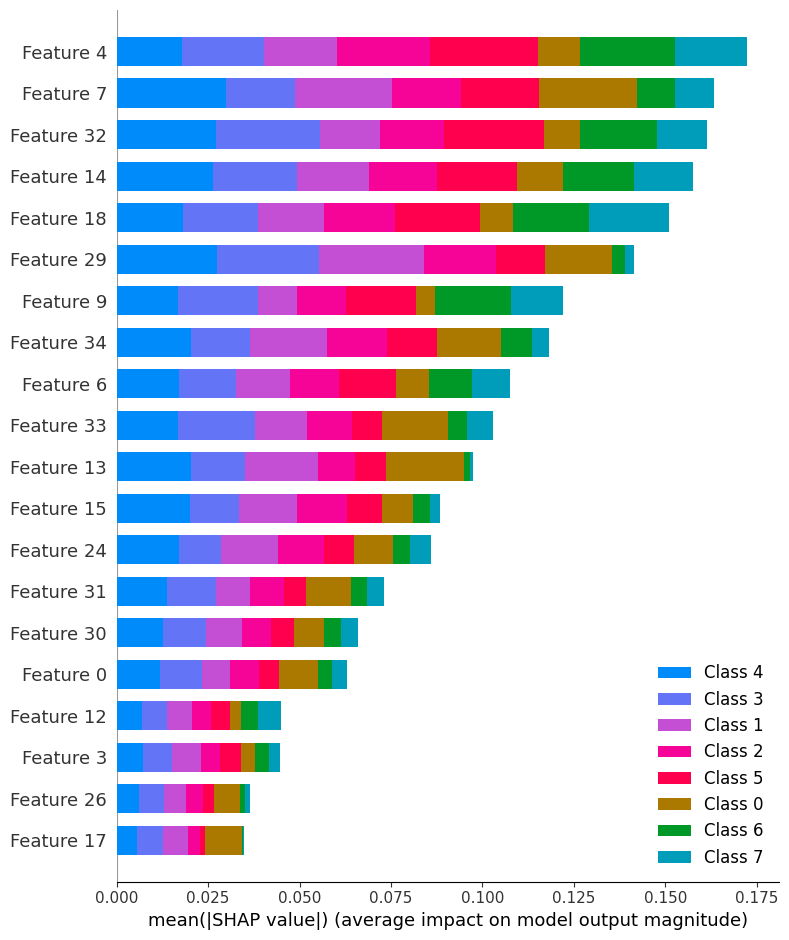

In [95]:
shap.summary_plot(shap_values, X.values)

In [26]:
X = df.drop(columns=['categoria_renda', 'uid', 'idfam', 'categoria_renda_corrigida'])#.values
y = df['categoria_renda_corrigida']#.values

for c in enumerate(X.columns):
    print(c)

(0, 'V0409____Quantos_cartoes_de_credito_tem')
(1, 'V0410____Quantas_contas_correntes_tem')
(2, 'ANOS_ESTUDO____Anos_de_estudo_da_pessoa_Variavel_derivada_construida_a_partir_dos_quesitos_referentes_a_educacao')
(3, 'V0205____Quantos_comodos_tem_este_domicilio')
(4, 'V0206____Quantos_comodos_estao_servindo_permanentemente_de_dormitorio_para_os_moradores_deste_domicilio')
(5, 'V02111____Quantos_banheiros_com_chuveiro_e_vaso_sanitario_de_uso_exclusivo_dos_moradores_existem_neste_domicilio_inclusive_os_localizados_no_terreno_ou_na_propriedade')
(6, 'pessoas_na_familia')
(7, 'imc_medio_familia')
(8, 'energia_kcal_medio_familia')
(9, 'anos_estudo_medio_familia')
(10, 'idade_media_familia')
(11, 'TIPO_SITUACAO_REG____Situacao_do_Domicilio_Urbano')
(12, 'V0405____Cor_ou_raca_Amarela')
(13, 'V0405____Cor_ou_raca_Branca')
(14, 'V0405____Cor_ou_raca_Indígena')
(15, 'V0405____Cor_ou_raca_Parda')
(16, 'V0405____Cor_ou_raca_Preta')
(17, 'V0405____Cor_ou_raca_Sem declaração')
(18, 'V0406_____tem_pla

In [96]:
shap.plots.beeswarm(shap_values)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.